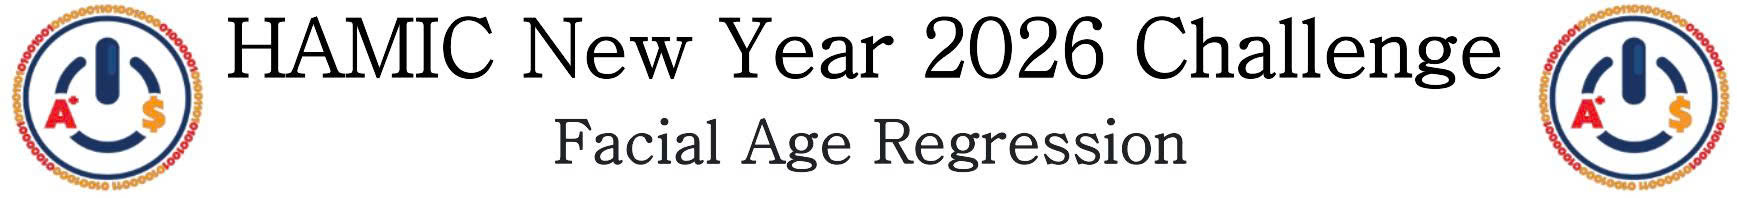

# HAMIC New Year 2026 Challenge - CV Task

## Starter Notebook
**Sử dụng Mô hình Học sâu (Deep Learning) cho bài toán Dự đoán Tuổi**

## Giới thiệu

Chào mừng bạn đến với HAMIC New Year 2026 Challenge!

Trong notebook khởi động này, chúng tôi sẽ hướng dẫn bạn quy trình xây dựng và huấn luyện một mô hình thị giác máy tính (sử dụng **ResNet18**) trên bộ dữ liệu khuôn mặt để giải quyết bài toán dự đoán độ tuổi (Age Estimation). Notebook này được thiết kế để chạy trên môi trường Google Colab hoặc máy cá nhân có GPU.

### Nội dung chính:

1.  **Cài đặt và Thư viện:** Thiết lập môi trường cần thiết.
2.  **Cấu hình:** Khai báo các tham số như tên mô hình, đường dẫn dữ liệu, siêu tham số.
3.  **Chuẩn bị Dữ liệu:** Tải ảnh, xử lý tên file để lấy nhãn (Age), và chia tập dữ liệu.
4.  **Dataset & DataLoader:** Tạo lớp Dataset của PyTorch để xử lý dữ liệu hình ảnh và Augmentation.
5.  **Kiến trúc Mô hình:** Định nghĩa mô hình dựa trên mạng CNN (ResNet18) được chỉnh sửa cho bài toán Hồi quy (Regression).
6.  **Huấn luyện:** Vòng lặp huấn luyện mô hình (Training Loop).
7.  **Dự đoán & Nộp bài:** Tạo file kết quả `submission.csv` trên tập kiểm tra.

**Trước khi bắt đầu:**
*   Khuyên dùng **GPU** để tăng tốc độ huấn luyện. Trong Colab: Chọn `Runtime` -> `Change runtime type` -> `GPU`.

### Bước 1: Tải và Chuẩn bị Dữ liệu

Đầu tiên, chúng ta tải dữ liệu từ GitHub. Vì dữ liệu ảnh có số lượng lớn và nằm trong thư mục, chúng ta sẽ clone toàn bộ repository.
Sau đó, chúng ta đọc file CSV và chia tập huấn luyện thành 2 phần: **Train** (để huấn luyện) và **Dev** (để đánh giá).


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Cấu hình đường dẫn
REPO_URL = "https://github.com/HaianCao/HAMIC_New_Year_2026_Challenge.git"
REPO_DIR = "HAMIC_New_Year_2026_Challenge"
DATA_DIR = os.path.join(REPO_DIR, "task-dataset/CV_Task")
IMAGES_DIR = os.path.join(DATA_DIR, "images")
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH = os.path.join(DATA_DIR, "test.csv")

In [2]:
# Hàm tải dữ liệu (Clone Repo)
def download_data():
    if not os.path.exists(REPO_DIR):
        print(f"Đang clone repository từ {REPO_URL}...")
        os.system(f"git clone {REPO_URL}")
        print("Đã tải xong.")
    else:
        print(f"{REPO_DIR} đã tồn tại.")

download_data()

Đang clone repository từ https://github.com/HaianCao/HAMIC_New_Year_2026_Challenge.git...
Đã tải xong.


In [3]:
# Đọc dữ liệu
if os.path.exists(TRAIN_PATH):
    df_full = pd.read_csv(TRAIN_PATH)
    df_test = pd.read_csv(TEST_PATH)

    # Kiểm tra dữ liệu
    print("Cột Train:", df_full.columns)
    print("Cột Test:", df_test.columns)

    # Chia tập Train/Dev (90/10) - Giữ tỷ lệ giống NLP Starter
    train_df, dev_df = train_test_split(df_full, test_size=0.1, random_state=42)

    print(f"Train size: {len(train_df)}")
    print(f"Dev size: {len(dev_df)}")
else:
    print("Vui lòng kiểm tra lại quá trình tải dữ liệu.")

Cột Train: Index(['ID', 'Filename', 'Age'], dtype='object')
Cột Test: Index(['ID', 'Filename'], dtype='object')
Train size: 17069
Dev size: 1897


### Bước 2: Xây dựng Dataset & DataLoader

Chúng ta tạo một lớp `FaceAgeDataset` kế thừa từ `torch.utils.data.Dataset`. Lớp này sẽ:
1.  Nhận dataframe chứa ID/Tên file và nhãn Tuổi (nếu có).
2.  Đọc ảnh từ đường dẫn, xử lý (transform) và trả về tensor.


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

BATCH_SIZE = 64
IMAGE_SIZE = 200

class FaceAgeDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, is_test=False):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Xác định tên file ảnh
        if 'Filename' in self.df.columns:
            img_name = self.df.iloc[idx]['Filename']
        else:
            img_name = f"face_{self.df.iloc[idx]['ID']}.jpg"

        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except (OSError, FileNotFoundError):
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color='black')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            age = self.df.iloc[idx]['Age']
            # Trả về age dưới dạng float tensor cho bài toán hồi quy
            return image, torch.tensor(age, dtype=torch.float32)

In [5]:
# Augmentation & Normalize
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tạo Dataset
if os.path.exists(TRAIN_PATH):
    train_dataset = FaceAgeDataset(train_df, IMAGES_DIR, transform=train_transform)
    dev_dataset = FaceAgeDataset(dev_df, IMAGES_DIR, transform=val_transform)

    # Tạo DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

### Bước 3: Xây dựng và Huấn luyện Mô hình

Chúng ta định nghĩa mô hình `AgeRegressor`:
-   **Backbone:** `resnet18` (pretrained trên ImageNet).
-   **Header:** Thay đổi lớp cuối cùng thành Linear layer với 1 output (dự đoán Tuổi).


In [6]:
import torch.nn as nn

class AgeRegressor(nn.Module):
    def __init__(self):
        super(AgeRegressor, self).__init__()
        self.backbone = models.resnet18(pretrained=True)

        # Thay đổi lớp cuối cùng cho bài toán Regression
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.backbone(x)

In [7]:
# Khởi tạo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = AgeRegressor().to(device)

# Optimizer & Loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss() # Loss cho Regression

# Hàm huấn luyện 1 epoch
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []

    for batch in tqdm(data_loader, desc="Training"):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(losses)

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [8]:
# Vòng lặp huấn luyện
EPOCHS = 3
if os.path.exists(TRAIN_PATH):
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Train MSE Loss: {train_loss:.4f}')

Epoch 1/3


Training: 100%|██████████| 267/267 [01:09<00:00,  3.87it/s]


Train MSE Loss: 256.7140
Epoch 2/3


Training: 100%|██████████| 267/267 [01:03<00:00,  4.19it/s]


Train MSE Loss: 70.2126
Epoch 3/3


Training: 100%|██████████| 267/267 [01:03<00:00,  4.22it/s]

Train MSE Loss: 60.7240


### Bước 4: Đánh giá Mô hình

Đánh giá hiệu suất trên tập Dev bằng RMSE (Root Mean Squared Error).


In [9]:
def eval_model(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predictions.extend(outputs.cpu().flatten().tolist())
            actual_labels.extend(labels.cpu().tolist())

    return np.array(actual_labels), np.array(predictions)

Evaluating: 100%|██████████| 30/30 [00:04<00:00,  7.34it/s]


Validation RMSE: 6.96


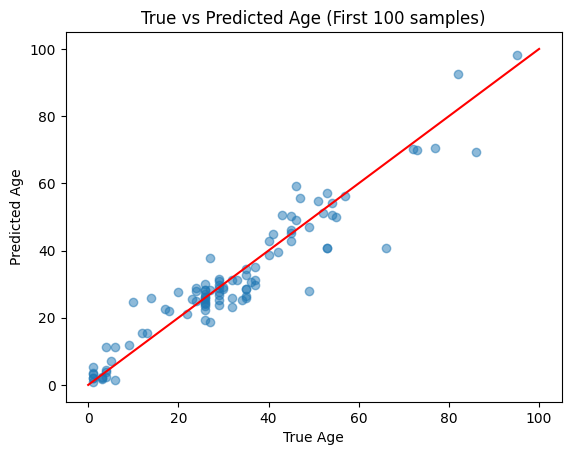

In [10]:
if os.path.exists(TRAIN_PATH):
    y_true, y_pred = eval_model(model, dev_loader, device)

    # Tính RMSE (Root Mean Squared Error)
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    print(f"Validation RMSE: {rmse:.2f}")

    # Vẽ biểu đồ so sánh
    plt.scatter(y_true[:100], y_pred[:100], alpha=0.5)
    plt.xlabel("True Age")
    plt.ylabel("Predicted Age")
    plt.title("True vs Predicted Age (First 100 samples)")
    plt.plot([0, 100], [0, 100], color='red')
    plt.show()

### Bước 5: Dự đoán và Tạo File Nộp bài

Cuối cùng, chạy mô hình trên tập **Test** (không có nhãn), dự đoán và lưu kết quả vào file `submission.csv`.


In [11]:
if os.path.exists(TEST_PATH):
    # Tạo Dataset cho Test
    test_dataset = FaceAgeDataset(df_test, IMAGES_DIR, transform=val_transform, is_test=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    # Dự đoán
    model.eval()
    test_preds = []

    with torch.no_grad():
        for images in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)
            outputs = model(images)
            preds = outputs.cpu().flatten().tolist()
            test_preds.extend([max(0, p) for p in preds])

    # Tạo DataFrame kết quả
    submission = pd.DataFrame({
        'ID': df_test['ID'],
        'Age': test_preds
    })

    # Lưu file
    submission.to_csv("submission.csv", index=False)
    print("Đã lưu submission.csv thành công!")
    print(submission.head())
else:
    print("Không tìm thấy file Test.")

Predicting: 100%|██████████| 75/75 [00:10<00:00,  7.49it/s]

Đã lưu submission.csv thành công!
      ID        Age
0  18967  28.544065
1  18968  47.943035
2  18969  31.962969
3  18970  28.116976
4  18971  19.229616
